In [1]:
'''This script demonstrates how to build a variational
   autoencoder with Keras having multiple heads with losses.

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
import os,sys
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import numpy as np
import random
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

import keras
from keras.layers import Input, Dense, Lambda, Layer, Concatenate
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import plot_model

# Set random seeds
def set_seed(seed_number = 0):
    pass
def set_seed_(seed_number = 0):

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed_number)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    random.seed(seed_number)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed_number)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

# Function for plotting the latent representation
def plot_latent_space(encoder, title = "", xlim = [-1.5, 1.5], ylim = [-1.5, 1.5]):
    # build a model to project inputs on the latent space
    if encoder.layers[-1].output_shape[-1] == 1:
        fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
        n_bins = 50
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
        for e_x, e_y, c in zip(x_test_red_list, y_test_red_list, colors[:len(x_test_red_list)]):
            # fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
            x_encoded = encoder.predict(e_x, batch_size=batch_size)
            ax.hist(x_encoded, bins=n_bins, facecolor=c, label=str(e_y[0]))
            #print(x_encoded)
        ax.legend()
        ax.set_xlim(xlim)
        ax.set_title(title)
    else:
        # display a 2D plot of the digit classes in the latent space
        x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
        plt.figure(figsize=(6, 6))
        plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
        plt.colorbar()
        #plt.axis("equal")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(title)
        plt.show()
        
def plot_observations(decoder, latent_values_x = list(np.arange(-2, 2.1, .1)), latent_values_y = list(np.arange(-2, 2.1, .1))):
    if decoder.layers[0].input_shape[-1] == 1:
        # Sample the observations
        x_decoded = decoder.predict(latent_values_x)
        # Show a sample of each set
        num_elements = len(x_decoded)
        f, ax = plt.subplots(1,num_elements,figsize=(int(3*num_elements),3), dpi=75)
        for e, idx in zip(x_decoded, range(num_elements)):
            ax[idx].imshow(e.reshape(28,28))
        plt.axis('off')
        plt.show()
    else: # == 2
        num_elements_x = len(latent_values_x)
        num_elements_y = len(latent_values_y)
        f, ax = plt.subplots(num_elements_y,num_elements_x,figsize=(int(3*num_elements_y),int(3*num_elements_x)), dpi=75)
        for idx, latent_value_x in zip(list(range(num_elements_x)), latent_values_x):
            for idy, latent_value_y in zip(list(range(num_elements_y))[::-1], latent_values_y):
                e = decoder.predict(np.asarray([[latent_value_x, latent_value_y]]))
                ax[idy, idx].imshow(e[0].reshape(28,28))
                ax[idy, idx].set_axis_off()
                ax[idy, idx].set_title((latent_value_y, latent_value_x))
        plt.show()
    
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [2]:
# Setup
batch_size = 129
original_dim = 784
latent_dim = 2
intermediate_dim = 64 # 128
epochs = 150
epsilon_std = 1.0
beta = 1.
alpha = .001
numbers = [1, 5, 0]

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


(60000, 784)


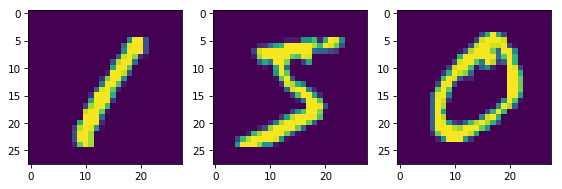

In [3]:
# Prep. the training and test set
print(x_train.shape)
x_train_red_list, x_test_red_list, y_train_red_list, y_test_red_list = [], [], [], []

for e in numbers:
    x_train_red_list.append(x_train[y_train == e,:])
    x_test_red_list.append(x_test[y_test == e,:])
    y_train_red_list.append(y_train[y_train == e])
    y_test_red_list.append(y_test[y_test == e])

# Make all datasets the same size
equalize_dataset = True
if equalize_dataset:
    min_elements = min([len(e) for e in y_train_red_list])
    y_train_red_list = [e[:min_elements] for e in y_train_red_list]
    x_train_red_list = [e[:min_elements] for e in x_train_red_list]
    
# Merge the data sets
x_train_red = np.concatenate(x_train_red_list)
x_test_red = np.concatenate(x_test_red_list)
y_train_red = np.concatenate(y_train_red_list)
y_test_red = np.concatenate(y_test_red_list)

# Copy back
x_train, x_test, y_train, y_test = x_train_red, x_test_red, y_train_red, y_test_red

# Define shuffled target dataset
idx_shuffle = np.arange(len(y_train_red_list[0]))
np.random.shuffle(idx_shuffle)
x_train_shuffle = np.concatenate([x_train_red_list[0][idx_shuffle], x_train_red_list[1][idx_shuffle], x_train_red_list[2][idx_shuffle]])

# Show a sample of each set
num_elements = len(x_train_red_list)
f, ax = plt.subplots(1,num_elements,figsize=(int(3*num_elements),3), dpi=75)
for e, idx in zip(x_train_red_list, range(num_elements)):
    ax[idx].imshow(e[0,:].reshape(28,28))
plt.show()

[1 1 5 ... 5 5 1]
[0 0 0 ... 1 0 0]
------- :20
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 5 5 1 5 5 1 5 5 5 1 5 1 1 5 1 1 1 5]
[0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1]
------- 9000:9020
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[5 1 5 5 5 1 1 5 5 1 5 1 1 1 5 5 5 5 5 5]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
------- -20:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0]
-------


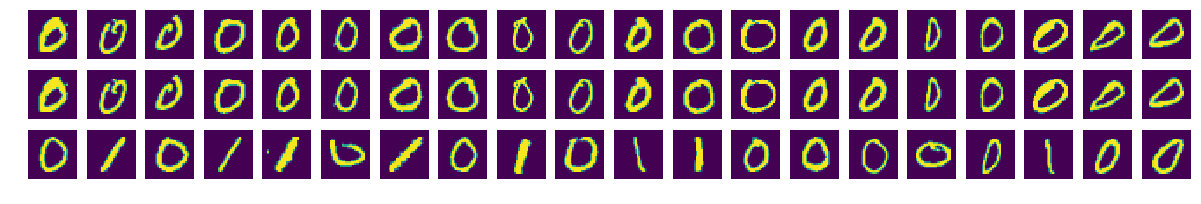

In [4]:
# mix 1&5 (*_1) and 1&0 (*_2) for uni-modal observations
[1, 5, 0]
idx_digit_0 = 0 # 1
idx_digit_1 = 1 # 5
idx_digit_2 = 2 # 0
def shuffle_set(idx_1, idx_2):
    x_train_red_mixed_list = np.concatenate([x_train_red_list[idx_1], x_train_red_list[idx_2]])
    y_train_red_mixed_list = np.concatenate([y_train_red_list[idx_1], y_train_red_list[idx_2]])

    idx_shuffle = np.arange(len(x_train_red_mixed_list))
    np.random.shuffle(idx_shuffle)

    x_train_red_mixed_list_ = x_train_red_mixed_list[idx_shuffle]
    y_train_red_mixed_list_ = y_train_red_mixed_list[idx_shuffle]
    
    print(y_train_red_mixed_list_)
    # split the shuffled list in half
    num_2 = int(len(y_train_red_mixed_list_) / 2)
    
    return [x_train_red_mixed_list_[:num_2], x_train_red_mixed_list_[num_2:]], [y_train_red_mixed_list_[:num_2], y_train_red_mixed_list_[num_2:]]
    
x_train_shuffled_01_list, y_train_shuffled_01_list =  shuffle_set(idx_digit_0, idx_digit_1)
x_train_shuffled_02_list, y_train_shuffled_02_list =  shuffle_set(idx_digit_0, idx_digit_2)

# Dataset for unimodal encoder 1: (1,5,0), where 1 and 5 are shuffled
x_train_1 = np.concatenate([x_train_shuffled_01_list[0], x_train_shuffled_01_list[1], x_train_red_list[idx_digit_2]])
y_train_1 = np.concatenate([y_train_shuffled_01_list[0], y_train_shuffled_01_list[1], y_train_red_list[idx_digit_2]])

# Dataset for unimodal encoder 2: (1,5,0), where 1 and 0 are shuffled
x_train_2 = np.concatenate([x_train_shuffled_02_list[0], x_train_red_list[idx_digit_1], x_train_shuffled_02_list[1]])
y_train_2 = np.concatenate([y_train_shuffled_02_list[0], y_train_red_list[idx_digit_1], y_train_shuffled_02_list[1]])


# show the mixing
print("------- :20")
print(y_train[:20])
print(y_train_1[:20])
print(y_train_2[:20])
print("------- 9000:9020")
print(y_train[9000:9020])
print(y_train_1[9000:9020])
print(y_train_2[9000:9020])
print("------- -20:")
print(y_train[-20:])
print(y_train_1[-20:])
print(y_train_2[-20:])
print("-------")

# Show a sample of each set
num_elements = 20
f, axs = plt.subplots(3,num_elements,figsize=(int(num_elements),3), dpi=75)
for idy, x_set in zip(range(3), [x_train, x_train_1, x_train_2]):
    for e, idx in zip(x_set[-20:], range(num_elements)):
        axs[idy, idx].imshow(e.reshape(28,28))
        axs[idy, idx].set_axis_off()
plt.show()


In [5]:
def vae_standard(use_shuffled_output = False):
    # Split custom loss layer
    set_seed()
    x_ref = Input(shape=(original_dim,))
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    h2 = Dense(int(intermediate_dim / 2), activation='relu')(h)
    z_mean = Dense(latent_dim)(h2)
    z_log_var = Dense(latent_dim)(h2)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h2 = Dense(int(intermediate_dim/2), activation='relu')
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h2_decoded = decoder_h2(z)
    h_decoded = decoder_h(h2_decoded)
    x_decoded_mean = decoder_mean(h_decoded)

    # Custom loss layer for reconstruction
    class CustomLossLayerReconstruction(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerReconstruction, self).__init__(**kwargs)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean = inputs[1]
            #rec_loss = K.mean(original_dim * metrics.binary_crossentropy(x, x_decoded_mean))
            rec_loss = K.mean(original_dim * metrics.mse(x, x_decoded_mean))
            self.add_loss(rec_loss, inputs=inputs)
            return rec_loss

    # Custom loss layer for kl-loss
    class CustomLossLayerKL(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerKL, self).__init__(**kwargs)

        def call(self, inputs):
            z_mean = inputs[0]
            z_log_var = inputs[1]
            kl_loss = - beta * 0.5 * K.mean(K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
            self.add_loss(kl_loss, inputs=inputs)
            return kl_loss

    y_ent_layer = CustomLossLayerReconstruction()
    y_kl_layer = CustomLossLayerKL()
    y_ent = y_ent_layer([x_ref, x_decoded_mean])
    y_kl = y_kl_layer([z_mean, z_log_var])
    vae = Model(inputs = [x, x_ref], outputs = [y_kl, y_ent])
    vae.compile(optimizer='adam', loss=None)
    
    vae.metrics_tensors.append(y_kl_layer.losses[0])
    vae.metrics_names.append("kl_loss")
    vae.metrics_tensors.append(y_ent_layer.losses[0])
    vae.metrics_names.append("rec_loss")
    
    #plot_model(vae, to_file='model.png')
    #plt.figure(figsize=(20,10))
    #plt.imshow(matplotlib.image.imread('model.png'))
    #plt.show()
    if use_shuffled_output:
        x_train_ref = x_train_shuffle
    else:
        x_train_ref = x_train
    h = vae.fit([x_train, x_train_ref],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, x_test], None),
            verbose = 1)
    
    z_input = Input(shape=(latent_dim,))
    decoder = Model(z_input, decoder_mean(decoder_h(decoder_h2(z_input))))
    encoder = Model(x, z_mean)
    return encoder, decoder, h

In [6]:
def vae_standard_2(use_shuffled_output = False):
    set_seed()
    x_ref = Input(shape=(original_dim,))
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    h2 = Dense(int(intermediate_dim / 2), activation='relu')(h)
    z_mean = Dense(latent_dim)(h2)
    z_log_var = Dense(latent_dim)(h2)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h2 = Dense(int(intermediate_dim/2), activation='relu')
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h2_decoded = decoder_h2(z)
    h_decoded = decoder_h(h2_decoded)
    x_decoded_mean = decoder_mean(h_decoded)

    vae = Model(inputs = [x, x_ref], outputs = x_decoded_mean)
    
    # Define losses
    rec_loss = K.mean(original_dim * metrics.mse(x_ref, x_decoded_mean))
    vae.add_loss(rec_loss)
    kl_loss = - beta * 0.5 * K.mean(K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
    vae.add_loss(kl_loss)
    vae.compile(optimizer='adam', loss=None)
    vae.metrics_tensors.append(rec_loss)
    vae.metrics_names.append("rec_loss")
    vae.metrics_tensors.append(kl_loss)
    vae.metrics_names.append("kl_loss")
    
    #plot_model(vae, to_file='model.png')
    plt.figure(figsize=(20,10))
    plt.imshow(matplotlib.image.imread('model.png'))
    plt.show()
    if use_shuffled_output:
        x_train_ref = x_train_shuffle
    else:
        x_train_ref = x_train
    h = vae.fit([x_train, x_train_ref],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, x_test], None),
            verbose = 2)
    
    z_input = Input(shape=(latent_dim,))
    decoder = Model(z_input, decoder_mean(decoder_h(decoder_h2(z_input))))
    encoder = Model(x, z_mean)
    return encoder, decoder, h

In [7]:
def vae_suzuki(use_shuffled_output = False):
    x_ref = Input(shape=(original_dim,))
    set_seed()
    # Bimodal encoder
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    h2 = Dense(int(intermediate_dim / 2), activation='relu')(h)
    z_mean = Dense(latent_dim)(h2)
    z_log_var = Dense(latent_dim)(h2)
    # Unimodal encoder 1
    x_1 = Input(shape=(original_dim,))
    h_1 = Dense(intermediate_dim, activation='relu')(x_1)
    h2_1 = Dense(int(intermediate_dim / 2), activation='relu')(h_1)
    z_mean_1 = Dense(latent_dim)(h2_1)
    z_log_var_1 = Dense(latent_dim)(h2_1)
    # Unimodal encoder 2
    x_2 = Input(shape=(original_dim,))
    h_2 = Dense(intermediate_dim, activation='relu')(x_2)
    h2_2 = Dense(int(intermediate_dim / 2), activation='relu')(h_2)
    z_mean_2 = Dense(latent_dim)(h2_2)
    z_log_var_2 = Dense(latent_dim)(h2_2)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h2 = Dense(int(intermediate_dim/2), activation='relu')
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h2_decoded = decoder_h2(z)
    h_decoded = decoder_h(h2_decoded)
    x_decoded_mean = decoder_mean(h_decoded)

    
    # Custom loss layer for reconstruction
    class CustomLossLayerJointKL(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerJointKL, self).__init__(**kwargs)

        def call(self, inputs):
            z_mean_bi = inputs[0]
            z_log_var_bi = inputs[1]
            z_mean_uni = inputs[2]
            z_log_var_uni = inputs[3]
            kl_loss = - alpha * .5 * K.mean(1 + z_log_var_bi - z_log_var_uni - ((K.exp(z_log_var_bi) + K.square(z_mean_bi - z_mean_uni)) / K.exp(z_log_var_uni)))
            self.add_loss(kl_loss, inputs=inputs)
            return kl_loss

    
    # Custom loss layer for reconstruction
    class CustomLossLayerReconstruction(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerReconstruction, self).__init__(**kwargs)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean = inputs[1]
            #rec_loss = K.mean(original_dim * metrics.binary_crossentropy(x, x_decoded_mean))
            rec_loss = K.mean(original_dim * metrics.mse(x, x_decoded_mean))
            self.add_loss(rec_loss, inputs=inputs)
            return rec_loss

    # Custom loss layer for kl-loss
    class CustomLossLayerKL(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerKL, self).__init__(**kwargs)

        def call(self, inputs):
            z_mean = inputs[0]
            z_log_var = inputs[1]
            kl_loss = - beta * 0.5 * K.mean(K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
            self.add_loss(kl_loss, inputs=inputs)
            return kl_loss

    y_ent   = CustomLossLayerReconstruction()([x_ref, x_decoded_mean])
    y_kl    = CustomLossLayerKL()([z_mean, z_log_var])
    y_kl_1  = CustomLossLayerJointKL()([z_mean, z_log_var, z_mean_1, z_log_var_1])
    y_kl_2  = CustomLossLayerJointKL()([z_mean, z_log_var, z_mean_2, z_log_var_2])
    vae = Model(inputs = [x, x_1, x_2, x_ref], outputs = [y_ent, y_kl, y_kl_1, y_kl_2])
    vae.compile(optimizer='adam', loss=None)
    #plot_model(vae, to_file='model.png')
    #plt.figure(figsize=(20,10))
    #plt.imshow(matplotlib.image.imread('model.png'))
    #plt.show()
    if use_shuffled_output:
        x_train_ref = x_train_shuffle
    else:
        x_train_ref = x_train
    h = vae.fit([x_train, x_train_1, x_train_2, x_train_ref],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, x_test, x_test, x_test], None),
            verbose = 1)
    
    z_input = Input(shape=(latent_dim,))
    decoder = Model(z_input, decoder_mean(decoder_h(decoder_h2(z_input))))
    encoder = Model(x, z_mean)
    encoder_1 = Model(x_1, z_mean_1)
    encoder_2 = Model(x_2, z_mean_2)
    return encoder, encoder_1, encoder_2, decoder, h

In [8]:
def vae_suzuki_2(use_shuffled_output = False):
    set_seed()
    x_ref = Input(shape=(original_dim,))
    # Bimodal encoder
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    h2 = Dense(int(intermediate_dim / 2), activation='relu')(h)
    z_mean = Dense(latent_dim)(h2)
    z_log_var = Dense(latent_dim)(h2)
    # Unimodal encoder 1
    x_1 = Input(shape=(original_dim,))
    h_1 = Dense(intermediate_dim, activation='relu')(x_1)
    h2_1 = Dense(int(intermediate_dim / 2), activation='relu')(h_1)
    z_mean_1 = Dense(latent_dim)(h2_1)
    z_log_var_1 = Dense(latent_dim)(h2_1)
    # Unimodal encoder 2
    x_2 = Input(shape=(original_dim,))
    h_2 = Dense(intermediate_dim, activation='relu')(x_2)
    h2_2 = Dense(int(intermediate_dim / 2), activation='relu')(h_2)
    z_mean_2 = Dense(latent_dim)(h2_2)
    z_log_var_2 = Dense(latent_dim)(h2_2)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h2 = Dense(int(intermediate_dim/2), activation='relu')
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h2_decoded = decoder_h2(z)
    h_decoded = decoder_h(h2_decoded)
    x_decoded_mean = decoder_mean(h_decoded)

    def kl_loss_bi(z_mean_bi, z_log_var_bi, z_mean_uni, z_log_var_uni):
        return - alpha * .5 * K.mean(1 + z_log_var_bi - z_log_var_uni - ((K.exp(z_log_var_bi) + K.square(z_mean_bi - z_mean_uni)) / K.exp(z_log_var_uni)))
     
    vae = Model(inputs = [x, x_1, x_2, x_ref], outputs = x_decoded_mean)
    
    # Define losses
    rec_loss = K.mean(original_dim * metrics.mse(x_ref, x_decoded_mean))
    vae.add_loss(rec_loss)
    kl_loss = - beta * 0.5 * K.mean(K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
    vae.add_loss(kl_loss)
    kl_loss_1 = kl_loss_bi(z_mean, z_log_var, z_mean_1, z_log_var_1)
    vae.add_loss(kl_loss_1)
    kl_loss_2 = kl_loss_bi(z_mean, z_log_var, z_mean_2, z_log_var_2)
    vae.add_loss(kl_loss_2)
    
    
    vae.compile(optimizer='adam', loss=None)
    vae.metrics_tensors.append(rec_loss)
    vae.metrics_names.append("rec_loss")
    vae.metrics_tensors.append(kl_loss)
    vae.metrics_names.append("kl_loss")
    vae.metrics_tensors.append(kl_loss_1)
    vae.metrics_names.append("kl_loss_1")
    vae.metrics_tensors.append(kl_loss_2)
    vae.metrics_names.append("kl_loss_2")
    
    #plot_model(vae, to_file='model.png')
    #plt.figure(figsize=(20,10))
    #plt.imshow(matplotlib.image.imread('model.png'))
    #plt.show()
    if use_shuffled_output:
        x_train_ref = x_train_shuffle
    else:
        x_train_ref = x_train
    h = vae.fit([x_train, x_train_1, x_train_2, x_train_ref],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, x_test, x_test, x_test], None),
            verbose = 1)
    
    z_input = Input(shape=(latent_dim,))
    decoder = Model(z_input, decoder_mean(decoder_h(decoder_h2(z_input))))
    encoder = Model(x, z_mean)
    encoder_1 = Model(x_1, z_mean_1)
    encoder_2 = Model(x_2, z_mean_2)
    return encoder, encoder_1, encoder_2, decoder, h

In [9]:
def vae_korthals(use_shuffled_output = False):
    x_ref = Input(shape=(original_dim,))
    set_seed(0)
    # Bimodal encoder
    x = Input(shape=(original_dim,))
    encoder_h = Dense(intermediate_dim, activation='relu')
    encoder_h2 = Dense(int(intermediate_dim / 2), activation='relu')
    h = encoder_h(x)
    h2 = encoder_h2(h)
    z_mean = Dense(latent_dim)(h2)
    z_log_var = Dense(latent_dim)(h2)
    # Unimodal encoder 1
    x_1 = Input(shape=(original_dim,))
    #h_1 = Dense(intermediate_dim, activation='relu')(x_1)
    #h2_1 = Dense(int(intermediate_dim / 2), activation='relu')(h_1)
    h2_1 = encoder_h2(encoder_h(x_1))
    z_mean_1 = Dense(latent_dim)(h2_1)
    z_log_var_1 = Dense(latent_dim)(h2_1)
    # Unimodal encoder 2
    x_2 = Input(shape=(original_dim,))
    #h_2 = Dense(intermediate_dim, activation='relu')(x_2)
    #h2_2 = Dense(int(intermediate_dim / 2), activation='relu')(h_2)
    h2_2 = encoder_h2(encoder_h(x_2))
    z_mean_2 = Dense(latent_dim)(h2_2)
    z_log_var_2 = Dense(latent_dim)(h2_2)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z   = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    z_1 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_1, z_log_var_1])
    z_2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_2, z_log_var_2])

    # we instantiate these layers separately so as to reuse them later
    decoder_h2 = Dense(int(intermediate_dim/2), activation='relu')
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    
    # Bimodal decoder
    h2_decoded = decoder_h2(z)
    h_decoded = decoder_h(h2_decoded)
    x_decoded_mean = decoder_mean(h_decoded)
    # Unimodal decoder 1
    h2_decoded_1 = decoder_h2(z_1)
    h_decoded_1 = decoder_h(h2_decoded_1)
    x_decoded_mean_1 = decoder_mean(h_decoded_1)
    # Unimodal decoder 2
    h2_decoded_2 = decoder_h2(z_2)
    h_decoded_2 = decoder_h(h2_decoded_2)
    x_decoded_mean_2 = decoder_mean(h_decoded_2)

    
    # Custom loss layer for reconstruction
    class CustomLossLayerJointKL(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerJointKL, self).__init__(**kwargs)

        def call(self, inputs):
            z_mean_bi = inputs[0]
            z_log_var_bi = inputs[1]
            z_mean_uni = inputs[2]
            z_log_var_uni = inputs[3]
            #kl_loss = - alpha * 0.1 * .5 * K.mean(1 + z_log_var_bi - z_log_var_uni - ((K.exp(z_log_var_bi) + K.square(z_mean_bi - z_mean_uni)) / K.exp(z_log_var_uni)))
            kl_loss = - alpha * .5 * K.mean(1 + z_log_var_bi - z_log_var_uni - ((K.exp(z_log_var_bi) + K.square(z_mean_bi - z_mean_uni)) / K.exp(z_log_var_uni)))
            self.add_loss(kl_loss, inputs=inputs)
            return kl_loss

    # Custom loss layer for reconstruction
    class CustomLossLayerReconstruction_bi(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerReconstruction_bi, self).__init__(**kwargs)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean = inputs[1]
            rec_loss = K.mean(original_dim * metrics.binary_crossentropy(x, x_decoded_mean))
            #rec_loss = 0.05 * K.mean(original_dim * metrics.mse(x, x_decoded_mean))
            self.add_loss(rec_loss, inputs=inputs)
            return rec_loss

    
    # Custom loss layer for reconstruction
    class CustomLossLayerReconstruction(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerReconstruction, self).__init__(**kwargs)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean = inputs[1]
            #rec_loss = K.mean(original_dim * metrics.binary_crossentropy(x, x_decoded_mean))
            rec_loss = K.mean(original_dim * metrics.mse(x, x_decoded_mean))
            self.add_loss(rec_loss, inputs=inputs)
            return rec_loss

    # Custom loss layer for kl-loss
    class CustomLossLayerKL(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomLossLayerKL, self).__init__(**kwargs)

        def call(self, inputs):
            z_mean = inputs[0]
            z_log_var = inputs[1]
            kl_loss = - beta * 0.5 * K.mean(K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
            self.add_loss(kl_loss, inputs=inputs)
            return kl_loss

    def kl_loss_bi(z_mean_bi, z_log_var_bi, z_mean_uni, z_log_var_uni):
        return - alpha * .5 * K.mean(1 + z_log_var_bi - z_log_var_uni - ((K.exp(z_log_var_bi) + K.square(z_mean_bi - z_mean_uni)) / K.exp(z_log_var_uni)))
     
    if True:
        #y_ent   = CustomLossLayerReconstruction()([x, x_decoded_mean])
        y_ent   = CustomLossLayerReconstruction_bi()([x_ref, x_decoded_mean])
        y_ent_1 = CustomLossLayerReconstruction()([x_ref, x_decoded_mean_1])
        y_ent_2 = CustomLossLayerReconstruction()([x_ref, x_decoded_mean_2])
        y_kl    = CustomLossLayerKL()([z_mean, z_log_var])
        y_kl_11 = CustomLossLayerKL()([z_mean_1, z_log_var_1])
        y_kl_22 = CustomLossLayerKL()([z_mean_2, z_log_var_2])
        y_kl_1  = CustomLossLayerJointKL()([z_mean, z_log_var, z_mean_1, z_log_var_1])
        y_kl_2  = CustomLossLayerJointKL()([z_mean, z_log_var, z_mean_2, z_log_var_2])
        vae = Model(inputs = [x, x_1, x_2, x_ref], outputs = [y_ent, y_ent_1, y_ent_2, y_kl, y_kl_1, y_kl_2, y_kl_11, y_kl_22])
    else:
        y_ent_1 = CustomLossLayerReconstruction()([x_ref, x_decoded_mean_1])
        y_ent_2 = CustomLossLayerReconstruction()([x_ref, x_decoded_mean_2])
        y_kl_22 = CustomLossLayerKL()([z_mean_2, z_log_var_2])
        y_kl_11 = CustomLossLayerKL()([z_mean_1, z_log_var_1])
        vae = Model(inputs = [x, x_1, x_2, x_ref], outputs = [y_ent_1, y_kl_11, y_ent_2, y_kl_22])
    #vae = Model(inputs = [x, x_1, x_2], outputs = [y_ent_1, y_ent_2, y_kl, y_kl_1, y_kl_2, y_kl_11, y_kl_22])
    vae.compile(optimizer='adam', loss=None)
    #plot_model(vae, to_file='model.png')
    #plt.figure(figsize=(20,10))
    #plt.imshow(matplotlib.image.imread('model.png'))
    #plt.show()
    #batch_size = 128
    #epochs = 100
    if use_shuffled_output:
        x_train_ref = x_train_shuffle
    else:
        x_train_ref = x_train
    h = vae.fit([x_train, x_train_1, x_train_2, x_train_ref],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, x_test, x_test, x_test], None),
            verbose = 1)
    
    z_input = Input(shape=(latent_dim,))
    decoder = Model(z_input, decoder_mean(decoder_h(decoder_h2(z_input))))
    encoder = Model(x, z_mean)
    encoder_1 = Model(x_1, z_mean_1)
    encoder_2 = Model(x_2, z_mean_2)
    return encoder, encoder_1, encoder_2, decoder, h

In [10]:
def vae_korthals_2(use_shuffled_output = False):
    x_ref = Input(shape=(original_dim,))
    set_seed(0)
    # Bimodal encoder
    x = Input(shape=(original_dim,))
    encoder_h = Dense(intermediate_dim, activation='relu')
    encoder_h2 = Dense(int(intermediate_dim / 2), activation='relu')
    h = encoder_h(x)
    h2 = encoder_h2(h)
    z_mean = Dense(latent_dim)(h2)
    z_log_var = Dense(latent_dim)(h2)
    # Unimodal encoder 1
    x_1 = Input(shape=(original_dim,))
    #h_1 = Dense(intermediate_dim, activation='relu')(x_1)
    #h2_1 = Dense(int(intermediate_dim / 2), activation='relu')(h_1)
    h2_1 = encoder_h2(encoder_h(x_1))
    z_mean_1 = Dense(latent_dim)(h2_1)
    z_log_var_1 = Dense(latent_dim)(h2_1)
    # Unimodal encoder 2
    x_2 = Input(shape=(original_dim,))
    #h_2 = Dense(intermediate_dim, activation='relu')(x_2)
    #h2_2 = Dense(int(intermediate_dim / 2), activation='relu')(h_2)
    h2_2 = encoder_h2(encoder_h(x_2))
    z_mean_2 = Dense(latent_dim)(h2_2)
    z_log_var_2 = Dense(latent_dim)(h2_2)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z   = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    z_1 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_1, z_log_var_1])
    z_2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean_2, z_log_var_2])

    # we instantiate these layers separately so as to reuse them later
    decoder_h2 = Dense(int(intermediate_dim/2), activation='relu')
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    
    # Bimodal decoder
    h2_decoded = decoder_h2(z)
    h_decoded = decoder_h(h2_decoded)
    x_decoded_mean = decoder_mean(h_decoded)
    # Unimodal decoder 1
    h2_decoded_1 = decoder_h2(z_1)
    h_decoded_1 = decoder_h(h2_decoded_1)
    x_decoded_mean_1 = decoder_mean(h_decoded_1)
    # Unimodal decoder 2
    h2_decoded_2 = decoder_h2(z_2)
    h_decoded_2 = decoder_h(h2_decoded_2)
    x_decoded_mean_2 = decoder_mean(h_decoded_2)

    def kl_loss_bi(z_mean_bi, z_log_var_bi, z_mean_uni, z_log_var_uni):
        return - alpha * .5 * K.mean(1 + z_log_var_bi - z_log_var_uni - ((K.exp(z_log_var_bi) + K.square(z_mean_bi - z_mean_uni)) / K.exp(z_log_var_uni)))
    
    vae = Model(inputs = [x, x_1, x_2, x_ref], outputs = x_decoded_mean)
    
    # Define losses
    rec_loss = K.mean(original_dim * metrics.mse(x_ref, x_decoded_mean))
    vae.add_loss(rec_loss)
    rec_loss_1 = K.mean(original_dim * metrics.mse(x_ref, x_decoded_mean_1))
    vae.add_loss(rec_loss_1)
    rec_loss_2 = K.mean(original_dim * metrics.mse(x_ref, x_decoded_mean_2))
    vae.add_loss(rec_loss_2)
    kl_loss = - beta * 0.5 * K.mean(K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
    vae.add_loss(kl_loss)
    kl_loss_1 = - beta * 0.5 * K.mean(K.sum(1 + z_log_var_1 - K.square(z_mean_1) - K.exp(z_log_var_1), axis=-1))
    vae.add_loss(kl_loss_1)
    kl_loss_2 = - beta * 0.5 * K.mean(K.sum(1 + z_log_var_2 - K.square(z_mean_2) - K.exp(z_log_var_2), axis=-1))
    vae.add_loss(kl_loss_2)
    kl_loss_uni1_bi = kl_loss_bi(z_mean, z_log_var, z_mean_1, z_log_var_1)
    vae.add_loss(kl_loss_uni1_bi)
    kl_loss_uni2_bi = kl_loss_bi(z_mean, z_log_var, z_mean_2, z_log_var_2)
    vae.add_loss(kl_loss_uni2_bi)
    
    
    vae.compile(optimizer='adam', loss=None)
    vae.metrics_tensors.append(rec_loss)
    vae.metrics_names.append("rec_loss")
    vae.metrics_tensors.append(rec_loss_1)
    vae.metrics_names.append("rec_loss_1")
    vae.metrics_tensors.append(rec_loss_2)
    vae.metrics_names.append("rec_loss_2")
    vae.metrics_tensors.append(kl_loss)
    vae.metrics_names.append("kl_loss")
    vae.metrics_tensors.append(kl_loss_1)
    vae.metrics_names.append("kl_loss_1")
    vae.metrics_tensors.append(kl_loss_2)
    vae.metrics_names.append("kl_loss_2")
    vae.metrics_tensors.append(kl_loss_uni1_bi)
    vae.metrics_names.append("kl_loss_uni1_bi")
    vae.metrics_tensors.append(kl_loss_uni2_bi)
    vae.metrics_names.append("kl_loss_uni2_bi")
    
    #plot_model(vae, to_file='model.png')
    #plt.figure(figsize=(20,10))
    #plt.imshow(matplotlib.image.imread('model.png'))
    #plt.show()
    #batch_size = 128
    #epochs = 100
    if use_shuffled_output:
        x_train_ref = x_train_shuffle
    else:
        x_train_ref = x_train
    h = vae.fit([x_train, x_train_1, x_train_2, x_train_ref],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, x_test, x_test, x_test], None),
            verbose = 1)
    
    z_input = Input(shape=(latent_dim,))
    decoder = Model(z_input, decoder_mean(decoder_h(decoder_h2(z_input))))
    encoder = Model(x, z_mean)
    encoder_1 = Model(x_1, z_mean_1)
    encoder_2 = Model(x_2, z_mean_2)
    return encoder, encoder_1, encoder_2, decoder, h

In [11]:
encoder_korthals, encoder_korthals_1, encoder_korthals_2, decoder_korthals, h_korthals = vae_korthals(True)
#encoder_korthals__2, encoder_korthals_1__2, encoder_korthals_2__2, decoder_korthals__2, h_korthals__2 = vae_korthals_2(True)
encoder_korthals__2, encoder_korthals_1__2, encoder_korthals_2__2, decoder_korthals__2, h_korthals__2 = vae_korthals(True)

Train on 16263 samples, validate on 3007 samples
Epoch 1/150
16263/16263 [==============================] - 2s 125us/step - loss: 429.6895 - val_loss: 303.7973
Epoch 2/150
16263/16263 [==============================] - 1s 39us/step - loss: 294.7405 - val_loss: 270.7176
Epoch 3/150
16263/16263 [==============================] - 1s 40us/step - loss: 277.3046 - val_loss: 264.7429
Epoch 4/150
16263/16263 [==============================] - 1s 38us/step - loss: 273.7419 - val_loss: 262.8360
Epoch 5/150
16263/16263 [==============================] - 1s 39us/step - loss: 271.1167 - val_loss: 260.6890
Epoch 6/150
16263/16263 [==============================] - 1s 38us/step - loss: 269.9336 - val_loss: 259.8957
Epoch 7/150
16263/16263 [==============================] - 1s 39us/step - loss: 269.2170 - val_loss: 259.4462
Epoch 8/150
16263/16263 [==============================] - 1s 38us/step - loss: 268.6527 - val_loss: 259.7224
Epoch 9/150
16263/16263 [==============================] - 1s 39us/ste

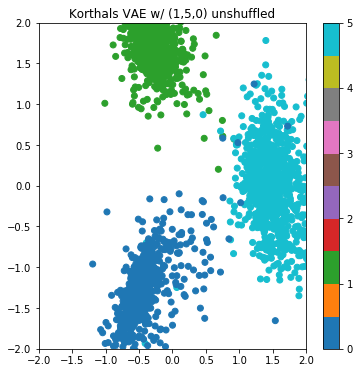

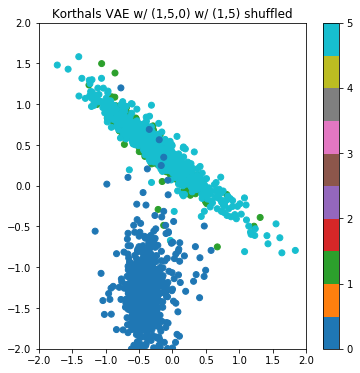

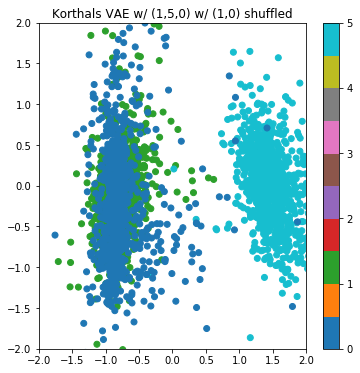

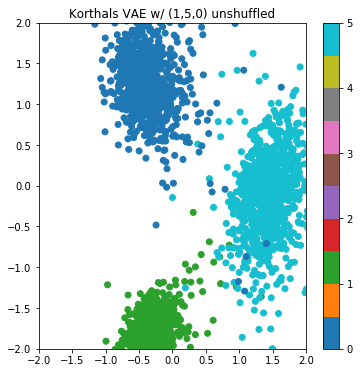

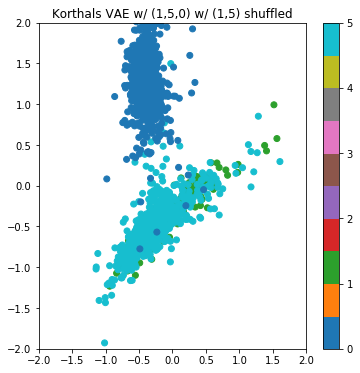

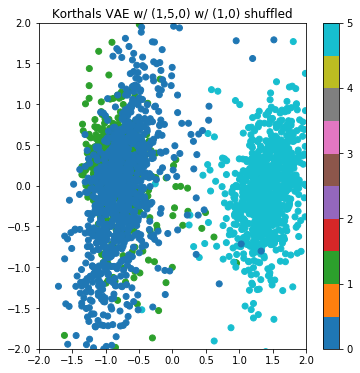

In [12]:
#plot_latent_space(encoder_korthals,   "Korthals VAE w/ (1,5,0) unshuffled", [-2,2])
#plot_latent_space(encoder_korthals_1, "Korthals VAE w/ (1,5,0) w/ (1,5) shuffled", [-2,2])
#plot_latent_space(encoder_korthals_2, "Korthals VAE w/ (1,5,0) w/ (1,0) shuffled", [-2,2])

plot_latent_space(encoder_korthals,   "Korthals VAE w/ (1,5,0) unshuffled", [-2,2], [-2,2])
plot_latent_space(encoder_korthals_1, "Korthals VAE w/ (1,5,0) w/ (1,5) shuffled", [-2,2], [-2,2])
plot_latent_space(encoder_korthals_2, "Korthals VAE w/ (1,5,0) w/ (1,0) shuffled", [-2,2], [-2,2])

plot_latent_space(encoder_korthals__2,   "Korthals VAE w/ (1,5,0) unshuffled", [-2,2], [-2,2])
plot_latent_space(encoder_korthals_1__2, "Korthals VAE w/ (1,5,0) w/ (1,5) shuffled", [-2,2], [-2,2])
plot_latent_space(encoder_korthals_2__2, "Korthals VAE w/ (1,5,0) w/ (1,0) shuffled", [-2,2], [-2,2])

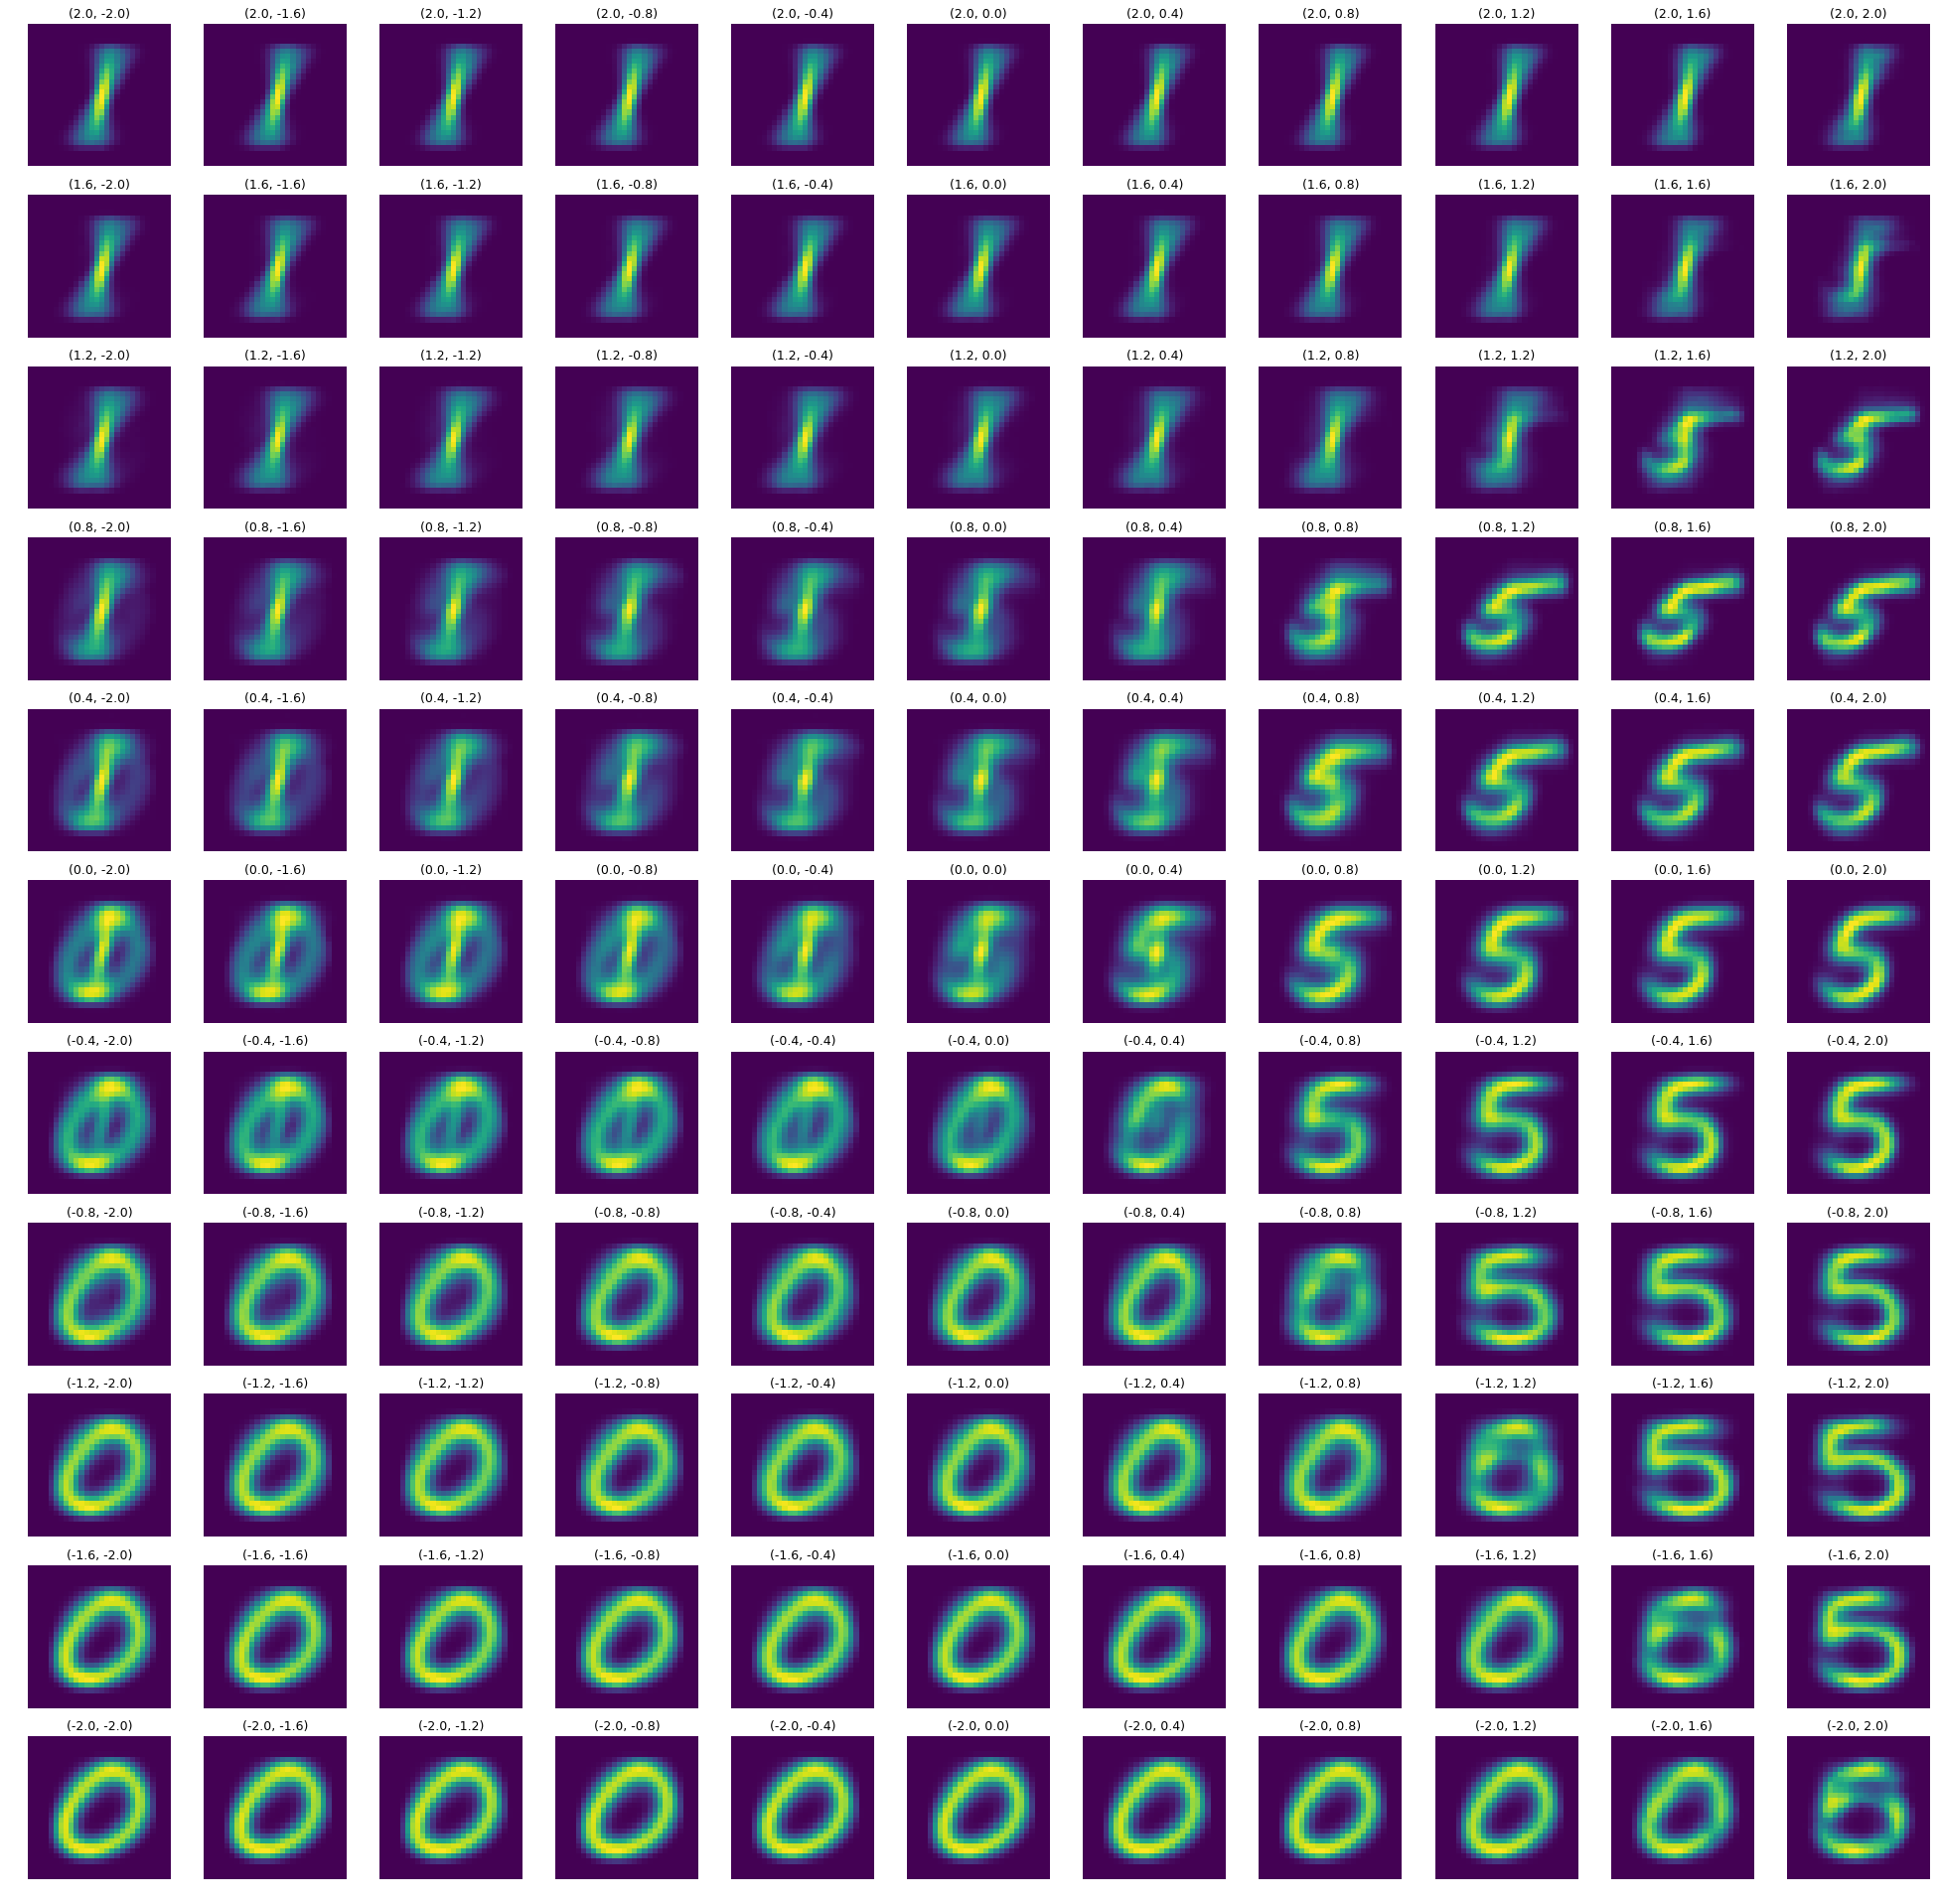

In [13]:
plot_observations(decoder_korthals, latent_values_x = np.around(np.linspace(-2, 2, 11, True),1), latent_values_y = np.around(np.linspace(-2, 2, 11, True),1))

In [14]:
encoder_suzuki, encoder_suzuki_1, encoder_suzuki_2, decoder_suzuki, h_suzuki = vae_suzuki(True)

Train on 16263 samples, validate on 3007 samples
Epoch 1/150
16263/16263 [==============================] - 1s 83us/step - loss: 77.5805 - val_loss: 51.8386
Epoch 2/150
16263/16263 [==============================] - 0s 30us/step - loss: 46.9078 - val_loss: 42.2917
Epoch 3/150
16263/16263 [==============================] - 0s 31us/step - loss: 43.8540 - val_loss: 41.1674
Epoch 4/150
16263/16263 [==============================] - 1s 34us/step - loss: 43.1834 - val_loss: 40.9857
Epoch 5/150
16263/16263 [==============================] - 0s 29us/step - loss: 42.9481 - val_loss: 40.8689
Epoch 6/150
16263/16263 [==============================] - 0s 30us/step - loss: 42.6542 - val_loss: 40.5871
Epoch 7/150
16263/16263 [==============================] - 0s 25us/step - loss: 42.5188 - val_loss: 40.4707
Epoch 8/150
16263/16263 [==============================] - 0s 25us/step - loss: 42.3970 - val_loss: 40.8310
Epoch 9/150
16263/16263 [==============================] - 0s 25us/step - loss: 42.3001

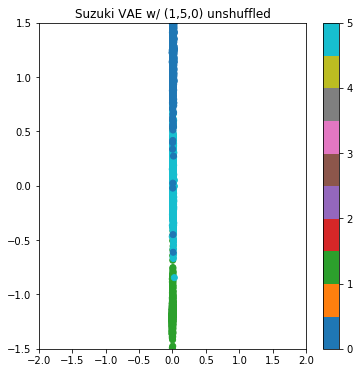

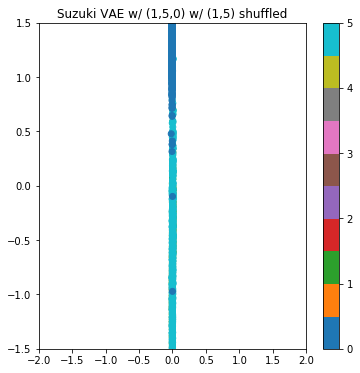

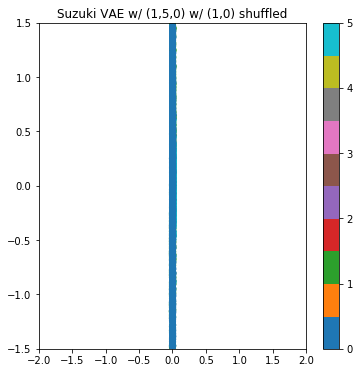

In [15]:
plot_latent_space(encoder_suzuki, "Suzuki VAE w/ (1,5,0) unshuffled", [-2,2])
plot_latent_space(encoder_suzuki_1, "Suzuki VAE w/ (1,5,0) w/ (1,5) shuffled", [-2,2])
plot_latent_space(encoder_suzuki_2, "Suzuki VAE w/ (1,5,0) w/ (1,0) shuffled", [-2,2])

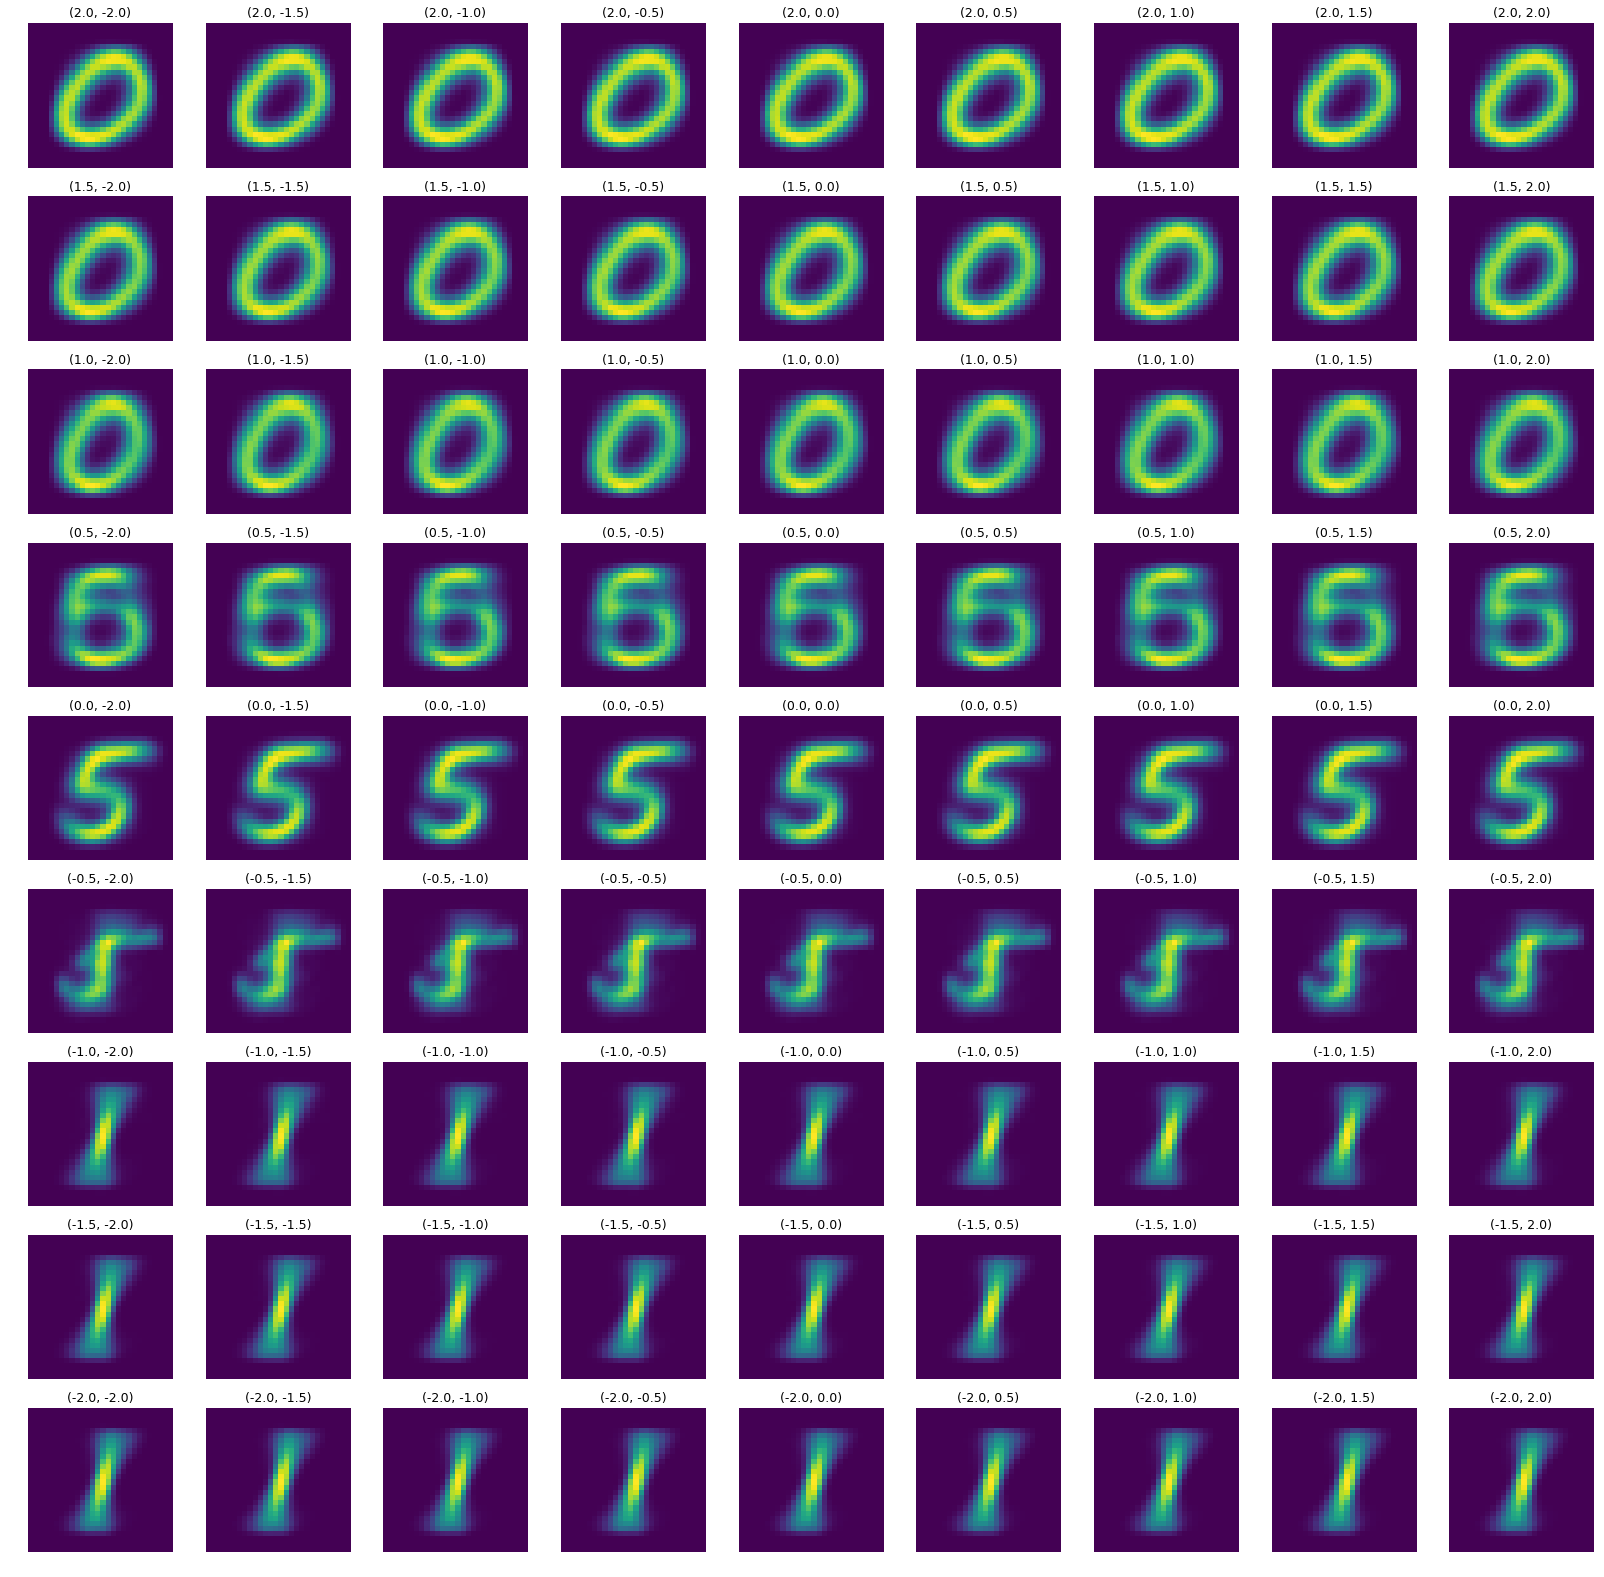

In [16]:
plot_observations(decoder_suzuki, latent_values_x = list(np.arange(-2, 2.1, .5)), latent_values_y = list(np.arange(-2, 2.1, .5)))

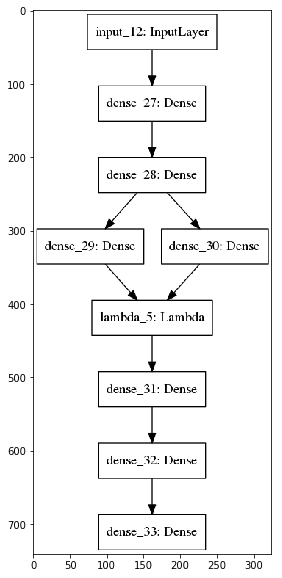

Train on 16263 samples, validate on 3007 samples
Epoch 1/150
 - 1s - loss: 81.0417 - rec_loss: 75.6700 - kl_loss: 5.3717 - val_loss: 45.8529 - val_rec_loss: 42.4426 - val_kl_loss: 3.4103
Epoch 2/150
 - 0s - loss: 45.9344 - rec_loss: 43.1732 - kl_loss: 2.7611 - val_loss: 42.6948 - val_rec_loss: 40.2151 - val_kl_loss: 2.4797
Epoch 3/150
 - 0s - loss: 44.1759 - rec_loss: 42.0966 - kl_loss: 2.0793 - val_loss: 41.4103 - val_rec_loss: 39.3337 - val_kl_loss: 2.0766
Epoch 4/150
 - 0s - loss: 43.3539 - rec_loss: 41.4737 - kl_loss: 1.8803 - val_loss: 41.0674 - val_rec_loss: 39.1886 - val_kl_loss: 1.8789
Epoch 5/150
 - 0s - loss: 43.0266 - rec_loss: 41.2405 - kl_loss: 1.7860 - val_loss: 40.8346 - val_rec_loss: 39.0226 - val_kl_loss: 1.8120
Epoch 6/150
 - 0s - loss: 42.8164 - rec_loss: 41.0840 - kl_loss: 1.7324 - val_loss: 40.8185 - val_rec_loss: 39.0137 - val_kl_loss: 1.8049
Epoch 7/150
 - 0s - loss: 42.6265 - rec_loss: 40.9598 - kl_loss: 1.6667 - val_loss: 40.9388 - val_rec_loss: 39.2286 - val_k

In [17]:
encoder_standard, decoder_standard, h_standard = vae_standard_2(True)
#encoder_standard, decoder_standard, h_standard = vae_standard(True)

#16263/16263 [==============================] - 1s 42us/step - loss: 44.7959 - kl_loss: 4.2491 - rec_loss: 40.5468 - val_loss: 44.5119 - val_kl_loss: 4.3422 - val_rec_loss: 40.1698

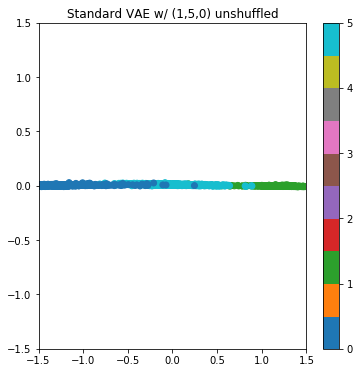

In [18]:
plot_latent_space(encoder_standard, "Standard VAE w/ (1,5,0) unshuffled")

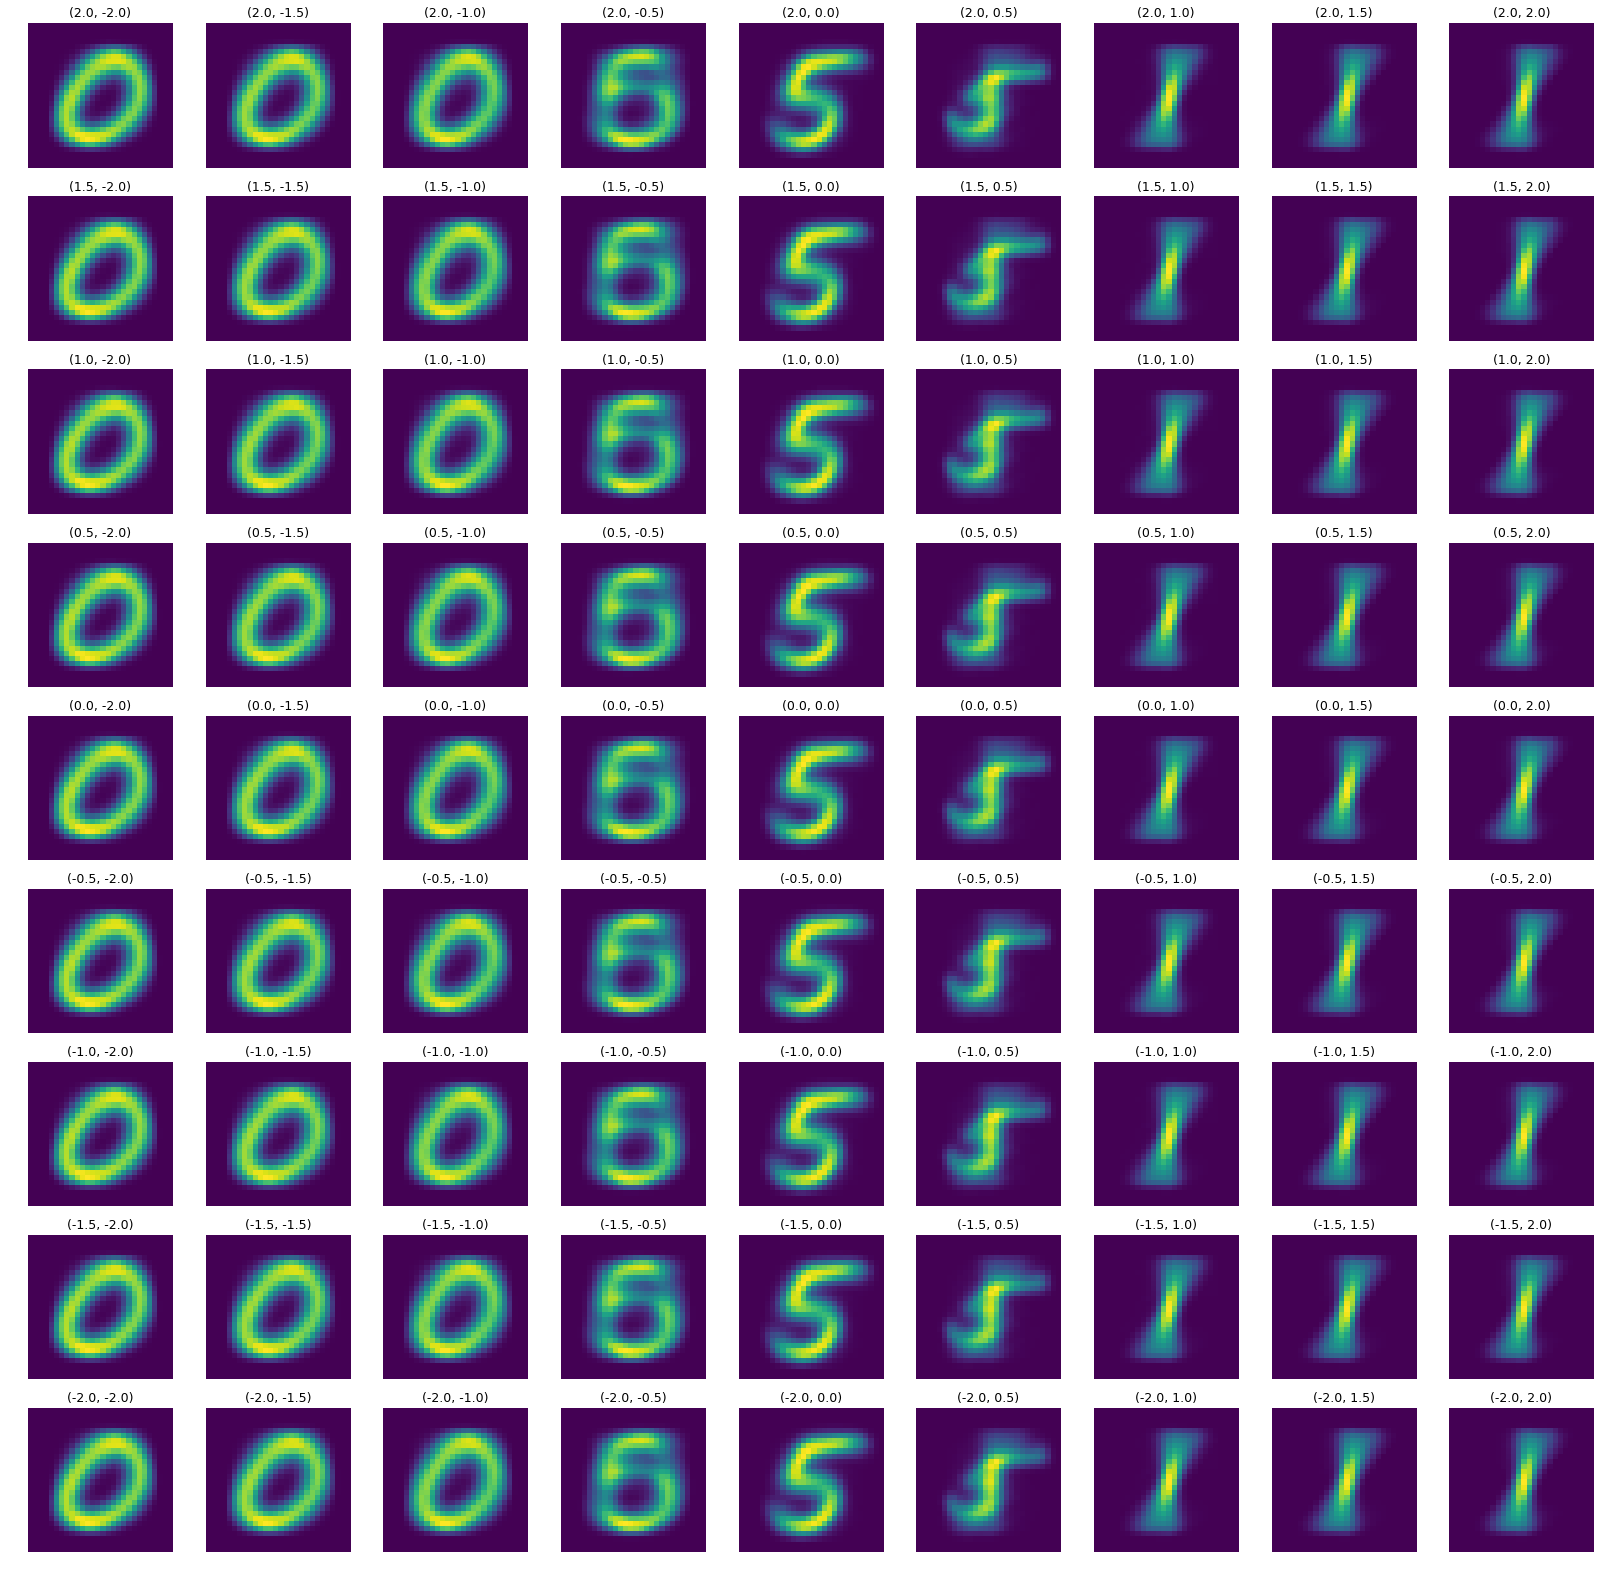

In [19]:
plot_observations(decoder_standard, latent_values_x = list(np.arange(-2, 2.1, .5)), latent_values_y = list(np.arange(-2, 2.1, .5)))

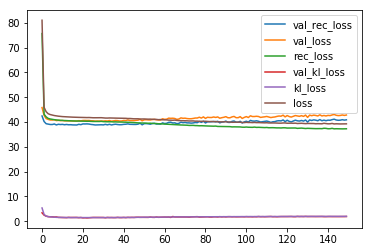

In [20]:
# Show both loss in one plot
for v in h_standard.history.values():
    plt.plot(v)
plt.legend(list(h_standard.history.keys()), loc='upper right')
plt.show()